Structure similarity investigation of GDB-13 fragrance-like molecules database 
TODO: Split into larger subsets, experiment with fingerprints 

In [1]:
# first attempt - fingerprint similarity comparison, no 3D structure 
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import rdkit.DataStructs


In [2]:
# convert SMI to csv - use pandas to convert text file to dataframe 
column_name=["Smiles"]
df = pd.read_csv('/home/martyn0000/fragrance_investigation/GDB-13-FL.smi',
                sep='\r\n', engine='python', names=column_name
                )
df = df.iloc[1: , :]
print(df.head(2))

df1 = df.iloc[:1000000,:]
print(df1.head(2))

df10M = df.iloc[:15000000, :]
print(df10M.head(2))

  Smiles
1    C#C
2  C1CC1
  Smiles
1    C#C
2  C1CC1
  Smiles
1    C#C
2  C1CC1


In [8]:
# try filtering on full dataset to see how much it can be reduced by - only from 59M to 58M. Try to find only the molecules containing oxygen - 53M, 815 MB of text. Restrict length to 8 and more atoms - still 53M  

#make a copy of main dataframe
df_sanitised = df.copy()
#loop through, remove S
regex_expression1 = "[Ss]"
filter1 = df_sanitised['Smiles'].str.contains(regex_expression1)
df_sanitised=df_sanitised[~filter1]
# remove N 
regex_expression2 = "[Nn]"
filter2 = df_sanitised['Smiles'].str.contains(regex_expression2)
df_sanitised=df_sanitised[~filter2]
# remove Cl 
regex_expression3 = "(Cl)"
filter3 = df_sanitised['Smiles'].str.contains(regex_expression3)
df_sanitised=df_sanitised[~filter3]
#keep only O 
regex_expression4 = "[Oo]"
filter4 = df_sanitised['Smiles'].str.contains(regex_expression4)
df_sanitisedO = df_sanitised[filter4]

# length filter 
regex_expression5 = "(\\s*[A-Z]\\W*\\s*){8}"
filter5 = df_sanitisedO['Smiles'].str.contains(regex_expression5)
df_shortened = df_sanitisedO[filter5]
#df_shortened = df_sanitisedO.loc[(df_sanitised['Smiles'].str.len() == 8)] doesn't work because special characters in SMILES are counted 
print(len(df_shortened.index))
print(df_shortened.head(5))


/tmp/ipykernel_2098/3040728775.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter3 = df_sanitised['Smiles'].str.contains(regex_expression3)
/tmp/ipykernel_2098/3040728775.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter5 = df_sanitisedO['Smiles'].str.contains(regex_expression5)


10102473
                Smiles
1027     OC[CH-]C#CC=O
1030  O=C[CH-]C(=O)C#C
2651          CCCCCCCO
2652        CC(C)CCCCO
2653      CC(C)(C)CCCO


In [9]:
# split len8 dataframe in three 

df8_1 = df_shortened.iloc[:3000000,:]
print(df8_1.head(2))

df8_2 = df.iloc[3000000:6000000, :]
print(df8_2.head(2))


df8_3 = df.iloc[6000000:, :]
print(df8_3.head(2))

                Smiles
1027     OC[CH-]C#CC=O
1030  O=C[CH-]C(=O)C#C
                         Smiles
3000001     CCCC1CC(C1)C#CCCC#C
3000002  CCCC1CC(CC(C)(C)C#C)C1
                             Smiles
6000001  CC1(C)CCC2CC(O)(C2)C(=O)O1
6000002    CC1(C)CCC2CC(O)C2C(=O)O1


In [5]:
# try molecule object and fingerprints separately
PandasTools.AddMoleculeColumnToFrame(df8_1,'Smiles','molecule',includeFingerprints=False)


/home/martyn0000/miniconda3/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


In [ ]:
from rdkit import rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs
# Generate atom pair fingerprints from mol object 
apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
df8_1['pairs'] = df8_1['molecule'].map(lambda x:Pairs.GetAtomPairFingerprintAsBitVect(x)) 
print(df8_1.head(2))

In [7]:
# rdkit calculate features - Morgan fingerprint (slow)

# convert SMILES to mol 
#PandasTools.AddMoleculeColumnToFrame(df8_1,'Smiles','molecule',includeFingerprints=True)
# Generate Morgan fingerprints from mol object 
df8_1['morgan'] = df8_1['molecule'].map(lambda x:GetMorganFingerprintAsBitVect(x,2)) 
print(df8_1.head(2))

KeyboardInterrupt: 

In [5]:
# storing dataframes 
df8_1.to_csv('df1_1M_with_fingerprints.csv')

In [ ]:
# try concatenating dataframes with fingerprints before similarity search 
frames = [df8_1, df8_2]
df_8 = pd.concat(frames)

In [ ]:
# similarity search of database (actually quite fast)
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity, DiceSimilarity
similarity_target=Chem.MolFromSmiles("C[C@@]1(C(C)=O)CC=C2CCCC(C)(C)[C@]2(C)[C@H]1C") 
def get_dataframe_with_x_most_similar_compounds_to_query(query, mol_df, molCol='molecule', x=int):
    query_fp = GetMorganFingerprintAsBitVect(query,2)
    mol_df['similarity'] = mol_df['morgan'].map(lambda x: TanimotoSimilarity(query_fp, x))
    mol_df.sort_values(['similarity'], ascending=False, inplace=True)
    return mol_df[:x].copy()  
similarity_df=get_dataframe_with_x_most_similar_compounds_to_query(similarity_target, df_shortened, x=50)
PandasTools.RenderImagesInAllDataFrames()
similarity_df.head(10)

In [ ]:
# run on multiple input dataframes, concatenate, sort by similarity 

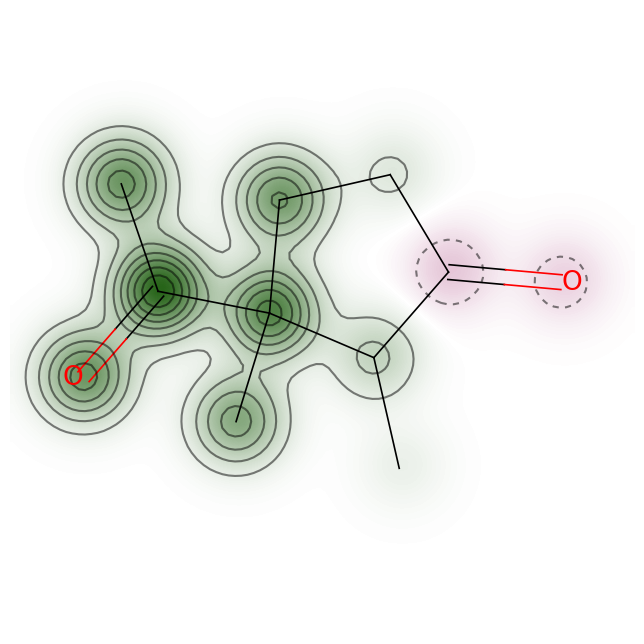

In [44]:
# generate similarity maps of most suitable candidates 

from rdkit.Chem import Draw 
from rdkit.Chem.Draw import SimilarityMaps
smiles=similarity_df["morgan"].to_list()

# get most similar molecule from dataframe, convert SMILES to molecule 
smiles_top_result = str(similarity_df['Smiles'].values[0])
mol_top_result = Chem.MolFromSmiles(smiles_top_result)

# generate similarity map
fp = SimilarityMaps.GetMorganFingerprint(mol_top_result, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(similarity_target, mol_top_result, SimilarityMaps.GetMorganFingerprint)

# TODO: get first n most similar molecules from dataframe (list), generate n similarity maps - need a function 